### Dairo Alberto Cuervo Garcia
#### Proyecto de grado - Exploración de discurso en cartas de maximos responsables - Maestría en Ciencias de los Datos y Analítica - Universidad EAFIT - 2024/1

## LSA - Latent Semantic Analysis

In [1]:
# Cargar librerias necesarias
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt

In [2]:
ruta_archivo_csv = r'C:\Users\DairoAlbertoCuervoGa\Downloads\Text_project\1.1.Output\Resultados.csv' # Cargar archivo csv
df = pd.read_csv(ruta_archivo_csv)

#### Creación de matriz TF-IDF

In [3]:
# Crear matriz TF-IDF
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=2, norm='l2', encoding='utf-8', ngram_range=(1, 1))
tf_idf_matrix = vectorizer.fit_transform(df['texto_lematizado'])

In [4]:
# Asignar la columna de empresa como índice de la matriz de similitud
similarity_matrix = pd.DataFrame(cosine_similarity(tf_idf_matrix), index=df['Empresa_Año'], columns=df['Empresa_Año'])

### Modelo LSA - Latent Semantic Analysis

In [5]:
n_temas = 5 # Número de temas para LSA, parámetrizado según método del codo

# Creación de la pipeline de LSA usando SVD truncado y normalización
svd = TruncatedSVD(n_components=n_temas)
normalizer = Normalizer(copy=False)
lsa_pipeline = make_pipeline(svd, normalizer)

# Aplicar LSA a la matriz TF-IDF
lsa_matrix = lsa_pipeline.fit_transform(tf_idf_matrix)

# Crear un DataFrame para visualizar los temas
lsa_df = pd.DataFrame(lsa_matrix, index=df['Empresa_Año'], columns=[f'Tema_{i}' for i in range(n_temas)]) # Cada fila representa un documento, y cada columna un tema

#### Fusionar dataframes y almacenar en csv de resultados los coeficientes de cada tema arrojados en LSA

In [6]:
# Fusionar el DataFrames
df_fusionado = df.merge(lsa_df, left_on='Empresa_Año', right_index=True)
ruta_archivo_resultados = r'C:\Users\DairoAlbertoCuervoGa\Downloads\Text_project\1.1.Output\Resultados.csv'
df_fusionado.to_csv(ruta_archivo_resultados)
print(lsa_df.head())

                      Tema_0    Tema_1    Tema_2    Tema_3    Tema_4
Empresa_Año                                                         
BancodeBogota_2018  0.889257  0.245722  0.355171 -0.149371 -0.019634
BancodeBogota_2019  0.930512  0.150787  0.327941 -0.062011  0.004532
BancodeBogota_2020  0.891750  0.238575  0.331326 -0.172792  0.090714
BancodeBogota_2021  0.893310  0.225571  0.357737 -0.150902  0.019181
BancodeBogota_2022  0.912318  0.136119  0.345380 -0.164580  0.052665


Para explorar las palabras claves de cada tema, extraemos la matriz de componentes, mostrando la importancia de cada palabra en cada tema

In [7]:
componentes = svd.components_
terminos = vectorizer.get_feature_names_out()

for i, tema in enumerate(componentes):
    terminos_importantes = tema.argsort()[-10:][::-1]  # Seleccionamos las 10 palabras más importantes por tema
    print(f"Tema {i+1}:")
    for termino in terminos_importantes:
        print(f"{terminos[termino]} ({tema[termino]:.4f})")
    print("")

Tema 1:
empresa (0.0842)
resultado (0.0818)
gestión (0.0799)
desarrollo (0.0796)
crecimiento (0.0794)
valor (0.0794)
negocio (0.0789)
sostenibilidad (0.0781)
financiero (0.0758)
mercado (0.0732)

Tema 2:
tasa (0.0980)
inflación (0.0975)
cartera (0.0884)
fiscal (0.0839)
peso (0.0837)
precio (0.0827)
semestre (0.0783)
dólar (0.0753)
gasto (0.0741)
desempleo (0.0734)

Tema 3:
vivienda (0.1332)
digital (0.1215)
cartera (0.0923)
cliente (0.0914)
crédito (0.0865)
producto (0.0853)
canal (0.0800)
enriquecer (0.0790)
persona (0.0769)
mensaje (0.0769)

Tema 4:
información (0.1183)
aspecto (0.1060)
informe (0.1059)
versión (0.1005)
materialidad (0.0977)
documento (0.0969)
marco (0.0875)
principio (0.0841)
gestión (0.0830)
global (0.0823)

Tema 5:
petróleo (0.1165)
barril (0.1087)
crudo (0.0991)
vivienda (0.0918)
comunidad (0.0900)
minero (0.0889)
reserva (0.0859)
producción (0.0784)
ambiental (0.0770)
comprometido (0.0759)



### Método del codo para determinar el número de temas optimo, con este se ajusta el modelo LSA.

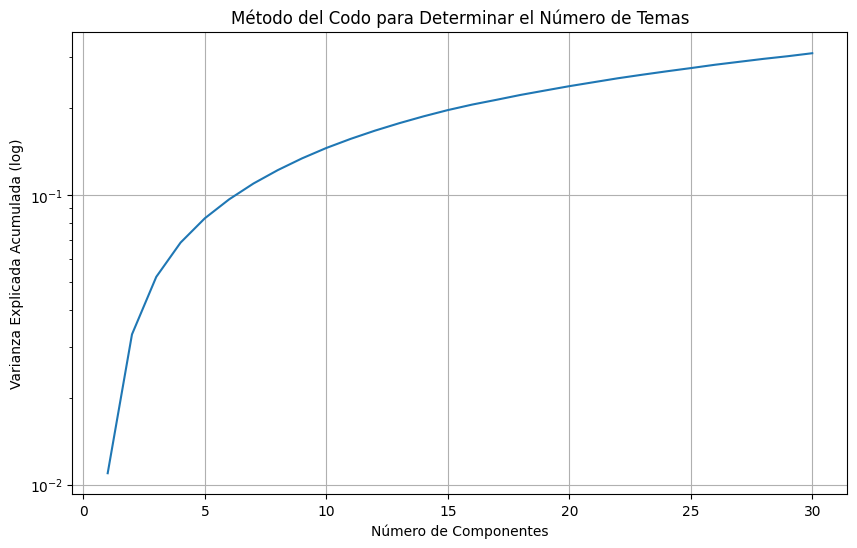

In [8]:
def graficar_varianza_explained(df, max_temas=100):
    data = df['texto_lematizado']
    tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, min_df=2)
    dtm_tfidf = tfidf_vectorizer.fit_transform(data)

    varianzas = []
    for n in range(1, max_temas + 1):
        svd = TruncatedSVD(n_components=n)
        svd.fit(dtm_tfidf)
        varianzas.append(svd.explained_variance_ratio_.sum())

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_temas + 1), varianzas)
    plt.yscale('log')  # Escala logarítmica en el eje Y
    plt.xlabel('Número de Componentes')
    plt.ylabel('Varianza Explicada Acumulada (log)')
    plt.title('Método del Codo para Determinar el Número de Temas')
    plt.grid(True)
    plt.show()

graficar_varianza_explained(df, max_temas=30)